In [117]:
# Imports

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal as mvn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title



In [118]:
# Utility Functions
def generate_data_from_gmm(N, n, pdf_params):

    # Decide randomly which samples will come from each Gaussian u_i ~ Uniform(0, 1) for i in {1, ..., N}
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    # Note how the samples from class 0 are weighted according to the mixture coefficients 'a' and THEN
    # the class prior probabilities contribute to how these pools are labelled... 
    # Try fiddling about with a_1 and a_2 to see the effects on the dataset generated (noting Class 0 samples)
    thresholds = np.cumsum(np.append(pdf_params['weights'].dot(pdf_params['priors'][0]), pdf_params['priors'][1]))
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    # Only 2 classes so can rely on single boolean condition to label samples
    labels = u >= pdf_params['priors'][0]
    X = np.zeros((N, n))
    num_gaussians = len(pdf_params['mean'])
    for i in range(1, num_gaussians+1):
        # Get randomly sampled indices for this Gaussian, checking between thresholds based on class priors
        indices = np.argwhere((thresholds[i-1] <= u) & (u <= thresholds[i]))[:, 0]
        X[indices, :] =  mvn.rvs(pdf_params['mean'][i-1], pdf_params['coVar'][i-1], len(indices))

    return X, labels



In [119]:
# Evaluation Functions
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    # The epsilon is just to account for the two extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas
def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(ind_11) / N_labels[1]

    return class_metrics

In [120]:
# Classifiers
def perform_lda(X, labels, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance matrix parameters would be estimated from training samples.
    
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    # First, estimate the class-conditional pdf mean and covariance matrices from samples
    # Note that reshape ensures my return mean vectors are of 2D shape (column vectors nx1)
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z
# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([mvn.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)


[6490 3510]


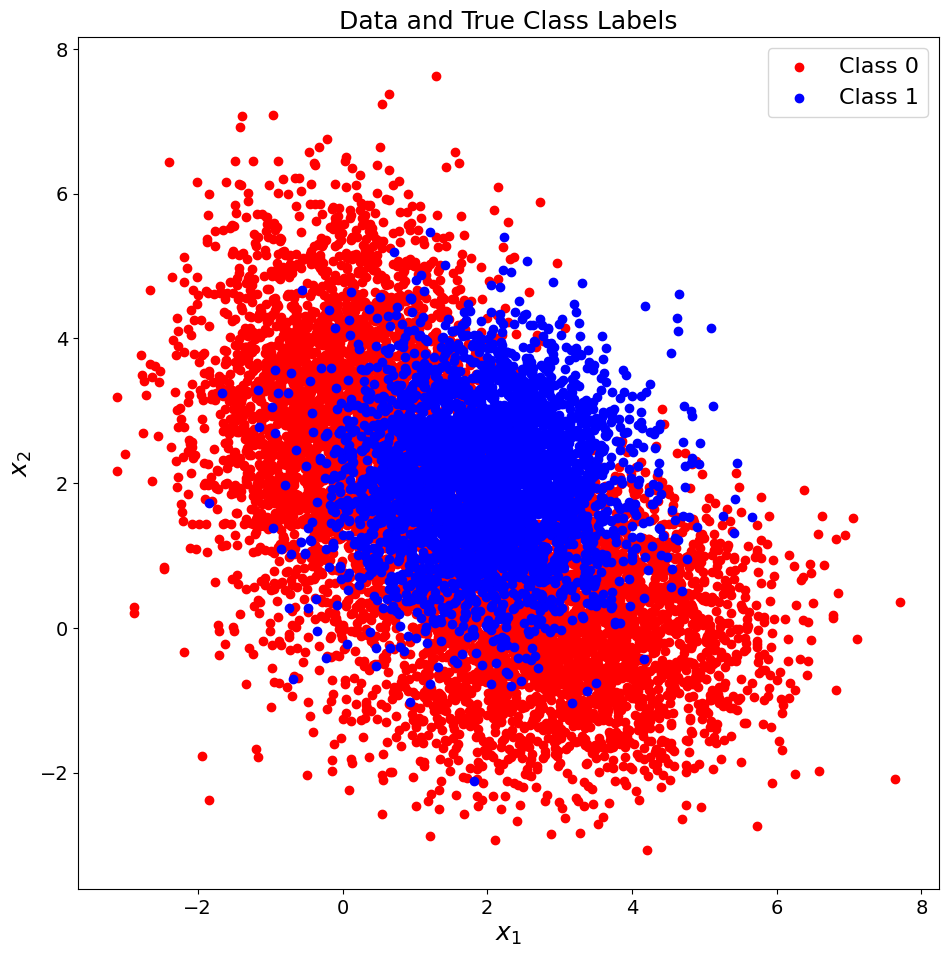

In [121]:
# Question 1 
# Generate dataset from two different 3D Gaussian distributions/categories
N = 10000

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.65, 0.35])
num_classes = len(gmm_pdf['priors'])
gmm_pdf['weights'] = np.array([0.5, 0.5])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['mean'] = np.array([[ 3, 0],
                            [0, 3],
                            [2, 2]]) 
gmm_pdf['coVar']  = np.array([[[2, 0],
                               [0, 1]],
                              [[1, 0],
                               [0, 2]],
                              [[1, 0],
                               [0, 1]]])

# Determine dimensionality from mixture PDF parameters
n = gmm_pdf['mean'].shape[1]
L = np.array(range(1, len(gmm_pdf['priors'])+1))
# Generate Data function
X, labels = generate_data_from_gmm(N, n, gmm_pdf)

n = X.shape[1]
L = np.array(range(num_classes))

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))

ax_raw = fig.add_subplot(111)
ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], c='r', label="Class 0")
ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], c='b', label="Class 1")
ax_raw.set_xlabel(r"$x_1$")
ax_raw.set_ylabel(r"$x_2$")
ax_raw.set_aspect('equal')

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()
plt.show()


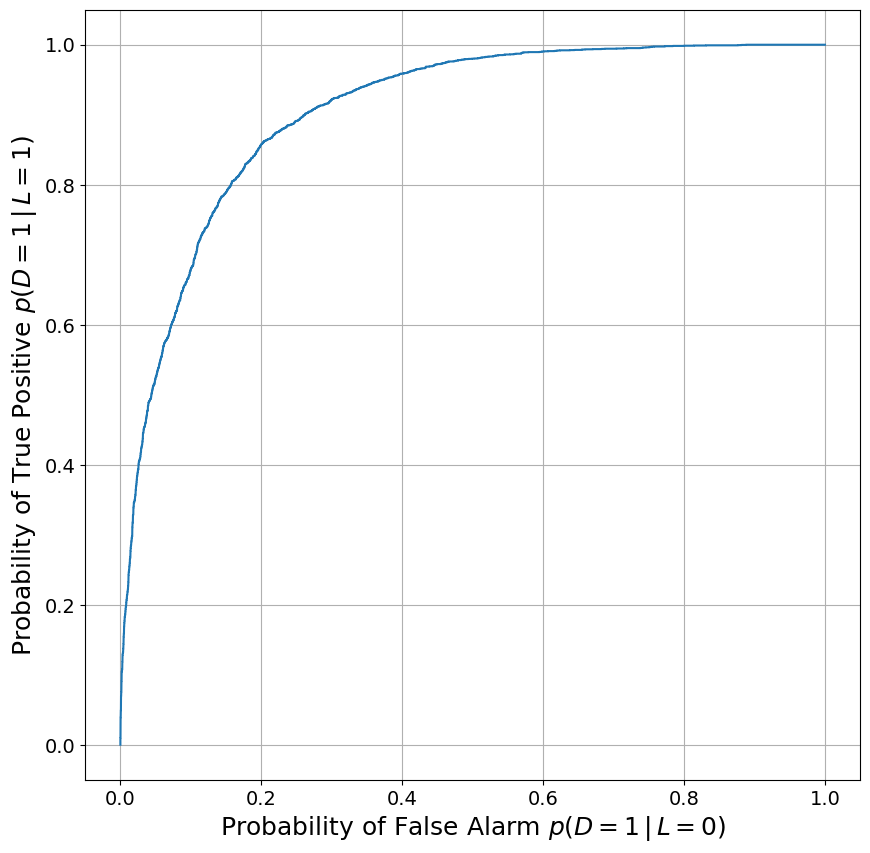

In [131]:
# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
class_conditional_likelihoods = np.array([mvn.pdf(X, gmm_pdf['mean'][0], gmm_pdf['coVar'][0]) + mvn.pdf(X, gmm_pdf['mean'][1], gmm_pdf['coVar'][1]), mvn.pdf(X, gmm_pdf['mean'][2], gmm_pdf['coVar'][2])])
# Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

plt.grid(True)
display(fig_roc)
fig_roc;


Min Empirical Pr(error) for ERM = 0.169
Min Empirical Gamma = 0.757
Min Theoretical Pr(error) for ERM = 0.190
Min Theoretical Gamma = 1.857


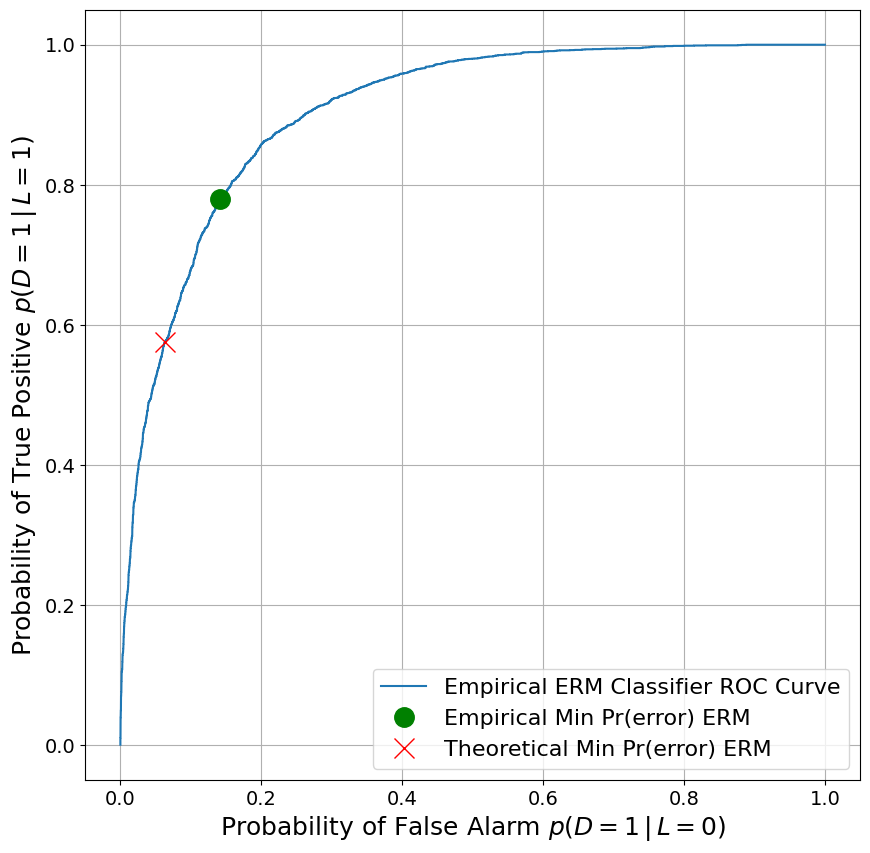

In [132]:
# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / N)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = gmm_pdf['priors'][0] / gmm_pdf['priors'][1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['FPR'] * gmm_pdf['priors'][0] + 
                               class_metrics_map['FNR'] * gmm_pdf['priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
plt.legend()

print("Min Empirical Pr(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)


Min LDA Pr(error) for ERM = 0.351
Min LDA Gamma = 3.000


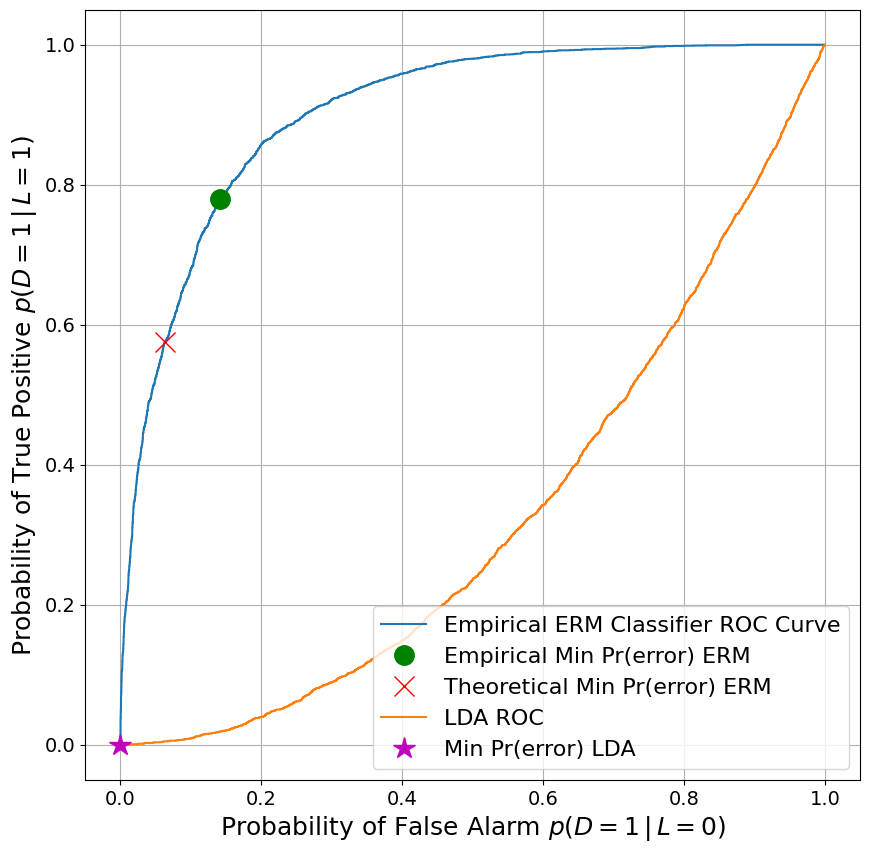

In [133]:
# Fisher LDA Classifer (using sample average estimates for model parameters)
_, discriminant_score_lda = perform_lda(X, labels)

# Estimate the ROC curve for this LDA classifier
roc_lda, gamma_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda['p10'], (1 - roc_lda['p11']))).T.dot(N_per_l / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind_lda = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda['p10'], roc_lda['p11'], label="LDA ROC")
ax_roc.plot(roc_lda['p10'][min_ind_lda], roc_lda['p11'][min_ind_lda], 'm*', label="Min Pr(error) LDA",  markersize=16)
ax_roc.legend()


print("Min LDA Pr(error) for ERM = {:.3f}".format(min_prob_error_lda))
print("Min LDA Gamma = {:.3f}".format(np.real(gamma_lda[min_ind_lda])))

display(fig_roc)